In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import argparse
import numpy as np
from run_vmc import main

def check_info(step, log, driver, save_path):
    if not isinstance(driver.info, dict):
        status = int(driver.info)
        if status != 0:
            print(f"Solver returned error status: {status}")
            np.save(save_path + "error_local_energies.npy", driver.state.local_estimators(driver._ham))
            print("Local energies saved...")
            return False
        else:
            return True
    return True

Single node computation
[CudaDevice(id=0)]


/mnt/home/rwiersema/netket_jaxmg/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


∣NK⟩ Tip: You can load logged data with nk.utils.history.HistoryDict.from_file(data.log).

AttributeError: 'Namespace' object has no attribute 'diag_shift'

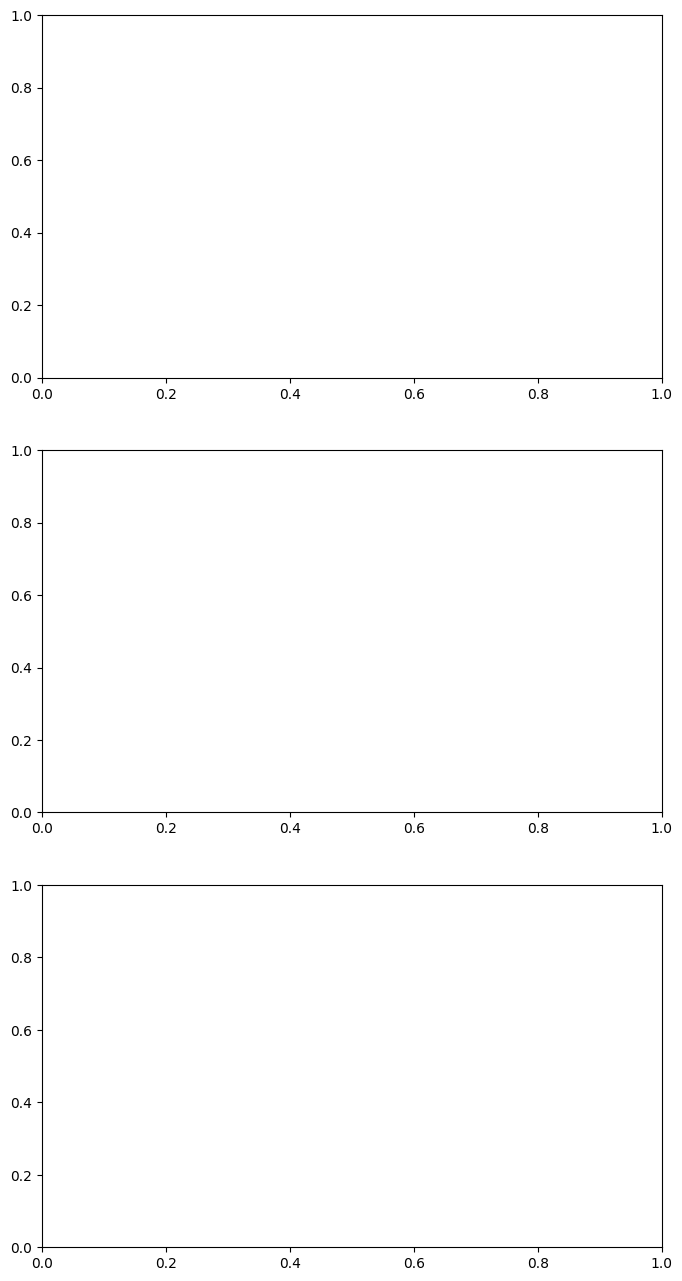

In [3]:
# Create figure with 3 subplots
fig, axs = plt.subplots(3, 1)
fig.set_size_inches(8, 16)
for i, power in enumerate(range(14, 20)):
    # Configuration dictionary
    ns = 2**power
    config = {
        "ns": ns,  # Number of samples
        "patch_size": 3,  # Effective patch size
        "num_layers": 2,  # Number of layers
        "d_model": 72,  # Model hidden vector size
        "heads": 12,  # Number of MHA heads
        "L": 12,  # Lattice size of 2D lattice
        "chunk_size": 2**12,  # Jacobian chunk size NTK
        "seed": 100,  # Seed
        "experiment_name": "Feb14",
    }

    # Convert to namespace for compatibility with get_data
    args = argparse.Namespace(**config)
    logger = main(args, return_logger=True)
    if not logger.restore():
        continue
    # Extract energy data
    L = config["L"]
    N = L**2
    energies_mean = np.array(logger.data["Energy"]["Mean"]) / (N * 4)
    energies_variance = np.array(logger.data["Energy"]["Variance"]) / (N * 4) ** 2

    # Plot 1: Mean energy (full trajectory)
    # Load loss data from loss.txt
    energies_mean_riccardo = np.loadtxt("loss.txt")
    if i == 0:
        axs[0].plot(
            energies_mean_riccardo, label="Mean Energy (Riccardo)", color="black"
        )
    axs[0].plot(energies_mean, label=f"ns={ns}")
    axs[0].set_xlabel("Step")
    axs[0].set_ylabel("Energy")
    axs[0].set_title("Mean Energy (Full Trajectory)")
    axs[0].legend()
    axs[0].grid(True)

    # Plot 2: Mean energy after first 1000 steps
    if i == 0:
        axs[1].plot(
            energies_mean_riccardo,
            label="Mean Energy (Riccardo after step 1000)",
            alpha=0.7,
            color="black",
        )
    axs[1].plot(energies_mean,label=f"ns={ns}", alpha=0.7)

    axs[1].set_xlabel("Step")
    # axs[1].set_xlim([100,500])
    axs[1].set_ylim(-0.555, -0.54)
    axs[1].set_xscale("log")
    axs[1].set_ylabel("Energy")
    axs[1].set_title("Mean Energy (After First 1000 Steps)")
    axs[1].legend()
    axs[1].grid(True)

    # Plot 3: Variance of energy
    axs[2].plot(energies_variance, label="Energy Variance")
    axs[2].set_xlabel("Step")

    axs[2].set_ylabel("Variance")
    axs[2].set_title("Energy Variance")
    axs[2].legend()
    axs[2].set_yscale("log")
    axs[2].set_xscale("log")
    axs[2].grid(True)

# plt.tight_layout()
plt.show()

Making path in process 0
Could not restore: ns=16384, diag_shift=1e-06, lr=0.03
Making path in process 0
Could not restore: ns=32768, diag_shift=1e-06, lr=0.03
Making path in process 0
Could not restore: ns=65536, diag_shift=1e-06, lr=0.03
Making path in process 0
Could not restore: ns=131072, diag_shift=1e-06, lr=0.03
Making path in process 0
Could not restore: ns=16384, diag_shift=1e-06, lr=0.06
Making path in process 0
Could not restore: ns=32768, diag_shift=1e-06, lr=0.06
Making path in process 0
Could not restore: ns=65536, diag_shift=1e-06, lr=0.06
Making path in process 0
Could not restore: ns=131072, diag_shift=1e-06, lr=0.06
Making path in process 0
Could not restore: ns=16384, diag_shift=1e-06, lr=0.12
Making path in process 0
Could not restore: ns=32768, diag_shift=1e-06, lr=0.12
Making path in process 0
Could not restore: ns=65536, diag_shift=1e-06, lr=0.12
Making path in process 0
Could not restore: ns=131072, diag_shift=1e-06, lr=0.12
Making path in process 0
Could not re

/mnt/home/rwiersema/netket_jaxmg/.venv/lib/python3.11/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/mnt/home/rwiersema/netket_jaxmg/.venv/lib/python3.11/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


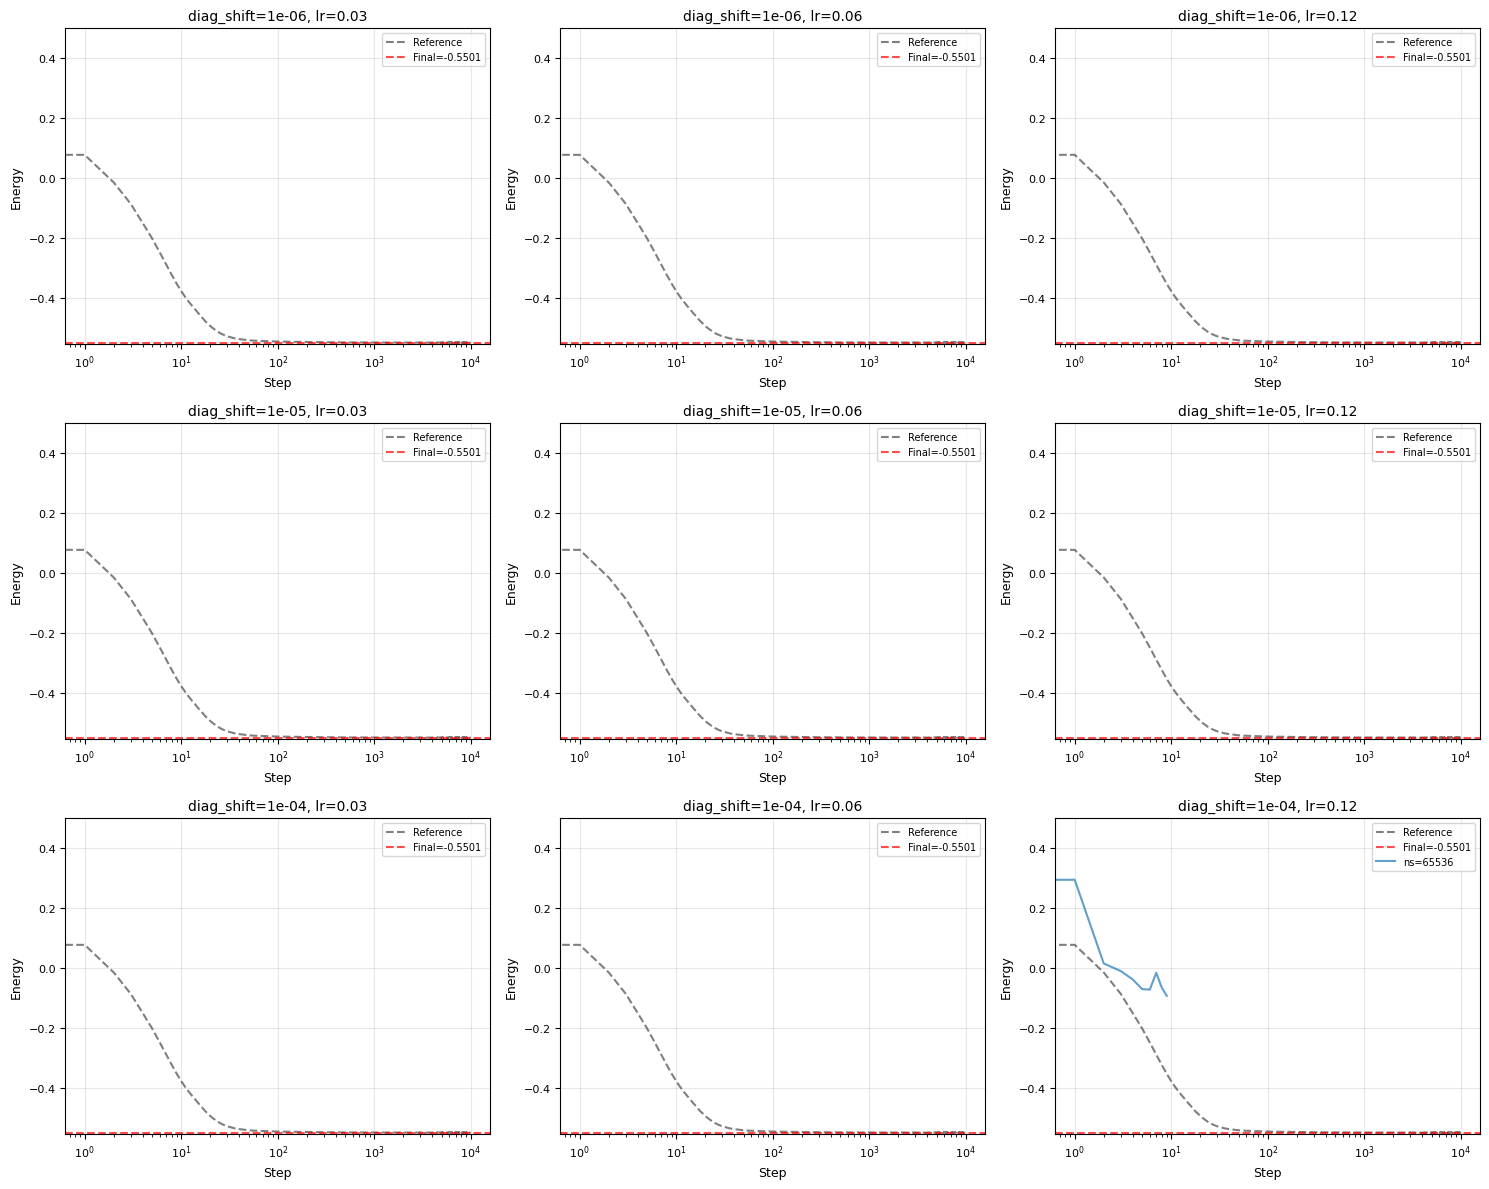

In [29]:
# Hyperparameter sweep results
diag_shifts = [1e-6, 1e-5, 1e-4]
lrs = [0.03,  0.06, 0.12]
Ns = [16384, 32768, 65536, 131072]
CSs = [-1, -1, 8192, 2048]
factor = 1
experiment_name = "Feb15"
# Create grid of subplots
fig, axs = plt.subplots(len(diag_shifts), len(lrs), figsize=(15, 12))

# Load reference data
energies_mean_riccardo = np.loadtxt("loss.txt")
final_energy = energies_mean_riccardo[-1]

for i, diag_shift in enumerate(diag_shifts):
    for j, lr in enumerate(lrs):
        ax = axs[i, j]
        
        # Plot reference line
        ax.plot(
            energies_mean_riccardo,
            label="Reference",
            alpha=0.5,
            color="black",
            linestyle="--",
            linewidth=1.5
        )
        
        # Plot final converged energy as horizontal dashed line
        ax.axhline(
            y=final_energy,
            color="red",
            linestyle="--",
            linewidth=1.5,
            alpha=0.7,
            label=f"Final={final_energy:.4f}"
        )
        
        # Plot for each sample count
        for k, (ns, cs) in enumerate(zip(Ns, CSs)):
            # Configuration dictionary
            config = {
                "ns": ns,
                "patch_size": 3,
                "num_layers": 2,
                "d_model": 72,
                "heads": 12,
                "L": 12,
                "chunk_size": cs if cs != -1 else 2**12,
                "seed": 100,
                "experiment_name": experiment_name,
                "diag_shift": diag_shift,
                "lr": lr,
                "thermalizing_steps":0,
                "q":None
            }
            
            # Convert to namespace and try to load data
            args = argparse.Namespace(**config)
            try:
                logger = main(args, return_logger=True)
                if not logger.restore():
                    print(f"Could not restore: ns={ns}, diag_shift={diag_shift}, lr={lr}")
                    continue
                
                # Extract and normalize energy data
                L = config["L"]
                N = L**2
                energies_mean = np.array(logger.data["Energy"]["Mean"]) / (N*factor)
                
                # Plot this run
                ax.plot(energies_mean, label=f"ns={ns}", alpha=0.7)
                
            except Exception as e:
                print(f"Error loading ns={ns}, diag_shift={diag_shift}, lr={lr}: {e}")
                continue
        
        # Configure subplot
        ax.set_xlabel("Step", fontsize=9)
        ax.set_ylabel("Energy", fontsize=9)
        ax.set_title(f"diag_shift={diag_shift:.0e}, lr={lr}", fontsize=10)
        ax.set_ylim(-0.555, 0.5)
        ax.set_xscale("log")
        ax.legend(fontsize=7, loc='best')
        ax.grid(True, alpha=0.3)
        ax.tick_params(labelsize=8)

plt.tight_layout()
plt.show()
